In [ ]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 23.7 MB/s eta 0:00:00


In [ ]:
#mean R2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs



# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_excel('HOMO-LUMO-energies.xlsx')

# Extract molecular structures and target
smiles_list = df["Smiles"].astype(str).tolist()
dff_values = df["dFF"].values

# -----------------------------
# Generate Morgan fingerprints (2048-bit, radius 2)
# -----------------------------
gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
mols = [Chem.MolFromSmiles(s) for s in smiles_list]

features = np.zeros((len(mols), 2048), dtype=np.uint8)
for i, m in enumerate(mols):
    if m is not None:
        fp = gen.GetFingerprint(m)
        DataStructs.ConvertToNumpyArray(fp, features[i])
    # if m is None: features row stays all zeros

# -----------------------------
# Train + Evaluate 200 times
# -----------------------------
r2_scores = []

with open('out-SVR-Morgan-linear.txt', 'w') as f:
    f.write("# Iteration\tR2\n")
    for i in range(200):
        # Split data
        x_train, x_test, y_train, y_test = train_test_split(
            features, dff_values, test_size=0.20, random_state=i
        )

        # Train SVR (linear kernel)
        regressor = SVR(kernel='linear')
        regressor.fit(x_train, y_train)

        # Predict + score
        y_pred = regressor.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

        f.write(f"{i}\t{r2:.6f}\n")
        print(f"Iteration {i}, R2 Score: {r2:.6f}")

    # Compute mean/std after loop
    mean_r2 = np.mean(r2_scores)
    std_r2 = np.std(r2_scores)
    f.write("\n")
    f.write(f"Mean R2 over 200 runs: {mean_r2:.6f}\n")
    f.write(f"Std  R2 over 200 runs: {std_r2:.6f}\n")

print("\nFinal Results:")
print(f"Mean R2: {mean_r2:.6f}")
print(f"Std  R2: {std_r2:.6f}")


Iteration 0, R2 Score: -0.071797
Iteration 1, R2 Score: -2.110634
Iteration 2, R2 Score: 0.214633
Iteration 3, R2 Score: 0.306664
Iteration 4, R2 Score: 0.235899
Iteration 5, R2 Score: 0.102017
Iteration 6, R2 Score: 0.347693
Iteration 7, R2 Score: -0.023952
Iteration 8, R2 Score: 0.440686
Iteration 9, R2 Score: 0.082958
Iteration 10, R2 Score: 0.293554
Iteration 11, R2 Score: -0.552358
Iteration 12, R2 Score: -0.151238
Iteration 13, R2 Score: 0.479576
Iteration 14, R2 Score: 0.260142
Iteration 15, R2 Score: 0.409353
Iteration 16, R2 Score: 0.182110
Iteration 17, R2 Score: 0.312625
Iteration 18, R2 Score: 0.551702
Iteration 19, R2 Score: 0.207516
Iteration 20, R2 Score: 0.324029
Iteration 21, R2 Score: 0.086188
Iteration 22, R2 Score: 0.463492
Iteration 23, R2 Score: 0.193848
Iteration 24, R2 Score: 0.478364
Iteration 25, R2 Score: 0.557855
Iteration 26, R2 Score: 0.206632
Iteration 27, R2 Score: 0.420276
Iteration 28, R2 Score: 0.040760
Iteration 29, R2 Score: 0.158639
Iteration 30, R

In [ ]:
# mean R2 for MACCS, Daylight, AtomPairs, Torsion, Avalon (SVR linear, 200 runs)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator as rfg
from rdkit.Avalon import pyAvalonTools

# -----------------------------
# Config
# -----------------------------
DATA_XLSX   = 'HOMO-LUMO-energies.xlsx'   # must have "Smiles" and "dFF"
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"
FP_SIZE     = 2048
N_RUNS      = 200
TEST_SIZE   = 0.20

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_excel(DATA_XLSX)
smiles_list = df[SMILES_COL].astype(str).tolist()
y = df[TARGET_COL].astype(float).values
mols = [Chem.MolFromSmiles(s) for s in smiles_list]

# -----------------------------
# Fingerprint generators
# -----------------------------
# RDKit new-style generators (stable sizes)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)
dayl_gen   = rfg.GetRDKitFPGenerator(fpSize=FP_SIZE, minPath=1, maxPath=7)  # Daylight-like

def fps_maccs(ms):
    return [MACCSkeys.GenMACCSKeys(m) if m is not None else None for m in ms]

def fps_daylight(ms):
    return [dayl_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_atompairs(ms):
    return [apair_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_torsion(ms):
    return [ttors_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_avalon(ms):
    return [pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE) if m is not None else None for m in ms]

# -----------------------------
# Helper: convert list of ExplicitBitVect -> numpy array
# -----------------------------
def bitvects_to_numpy(bitvects):
    # infer bit length from first non-None fp
    first = next((fp for fp in bitvects if fp is not None), None)
    if first is None:
        raise ValueError("All fingerprints are None (invalid SMILES?)")
    n_bits = len(first)
    X = np.zeros((len(bitvects), n_bits), dtype=np.uint8)
    for i, fp in enumerate(bitvects):
        if fp is not None:
            DataStructs.ConvertToNumpyArray(fp, X[i])
        # if None, row stays zeros
    return X

# -----------------------------
# Core evaluator (same style as your Morgan code)
# -----------------------------
def evaluate_fp(fp_name, fp_builder):
    fps = fp_builder(mols)
    X = bitvects_to_numpy(fps)

    r2_scores = []
    fname = f'out-SVR-{fp_name}-linear.txt'.replace(" ", "")
    with open(fname, 'w') as f:
        f.write("# Iteration\tR2\n")
        for i in range(N_RUNS):
            x_tr, x_te, y_tr, y_te = train_test_split(
                X, y, test_size=TEST_SIZE, random_state=i
            )
            reg = SVR(kernel='linear')
            reg.fit(x_tr, y_tr)
            y_pred = reg.predict(x_te)
            r2 = r2_score(y_te, y_pred)
            r2_scores.append(r2)
            f.write(f"{i}\t{r2:.6f}\n")
            print(f"[{fp_name}] Iteration {i:3d}, R2: {r2:.6f}")

        mean_r2 = float(np.mean(r2_scores))
        std_r2  = float(np.std(r2_scores))
        f.write("\n")
        f.write(f"Mean R2 over {N_RUNS} runs: {mean_r2:.6f}\n")
        f.write(f"Std  R2 over {N_RUNS} runs: {std_r2:.6f}\n")

    print(f"\n[{fp_name}] Final Results:")
    print(f"Mean R2: {mean_r2:.6f}")
    print(f"Std  R2: {std_r2:.6f}\n")
    return fp_name, mean_r2, std_r2

# -----------------------------
# Run all requested fingerprints
# -----------------------------
summary = []
for name, builder in [
    ("MACCS",     fps_maccs),
    ("Daylight",  fps_daylight),
    ("AtomPairs", fps_atompairs),
    ("Torsion",   fps_torsion),
    ("Avalon",    fps_avalon),
]:
    summary.append(evaluate_fp(name, builder))

# Print a compact summary table
print("=== Mean ± Std R2 over 200 runs (SVR linear) ===")
for name, mean_r2, std_r2 in summary:
    print(f"{name:10s}  {mean_r2:.6f} ± {std_r2:.6f}")


[MACCS] Iteration   0, R2: -0.312550
[MACCS] Iteration   1, R2: -4.058122
[MACCS] Iteration   2, R2: 0.516124
[MACCS] Iteration   3, R2: 0.066917
[MACCS] Iteration   4, R2: 0.117251
[MACCS] Iteration   5, R2: -0.054019
[MACCS] Iteration   6, R2: 0.120293
[MACCS] Iteration   7, R2: 0.039688
[MACCS] Iteration   8, R2: -0.713817
[MACCS] Iteration   9, R2: 0.354975
[MACCS] Iteration  10, R2: -0.617423
[MACCS] Iteration  11, R2: -1.631204
[MACCS] Iteration  12, R2: -0.510655
[MACCS] Iteration  13, R2: 0.473428
[MACCS] Iteration  14, R2: 0.227252
[MACCS] Iteration  15, R2: 0.143583
[MACCS] Iteration  16, R2: -0.088831
[MACCS] Iteration  17, R2: -0.355890
[MACCS] Iteration  18, R2: 0.331688
[MACCS] Iteration  19, R2: -1.623838
[MACCS] Iteration  20, R2: -0.151678
[MACCS] Iteration  21, R2: -0.155810
[MACCS] Iteration  22, R2: 0.428806
[MACCS] Iteration  23, R2: -0.489984
[MACCS] Iteration  24, R2: -0.969572
[MACCS] Iteration  25, R2: -0.124709
[MACCS] Iteration  26, R2: -0.972378
[MACCS] Iter

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem
from rdkit.Chem import AllChem

# Load dataset
df = pd.read_excel('HOMO-LUMO-energies.xlsx')

# Extract molecular structures and properties
smiles_list = df["Smiles"]
dff_values = df["dFF"]  # Used for predicting dFF

# Generate Morgan fingerprints
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
from rdkit.Chem import rdFingerprintGenerator

# Create a Morgan generator (once)
fingerprints = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)
len(mols)

# Convert fingerprints to NumPy arrays
fingerprints_array = np.array([np.array(fp) for fp in fingerprints])

# --------------------- Train and Evaluate SVR Model ---------------------
# Split the dataset into training and testing data (using only fingerprints)
features = fingerprints_array  # Only use fingerprints, exclude HOMO and LUMO values

# Open the file to save the R2 scores for all iterations
with open('out-SVR-Morgan-linear.txt', 'w') as f:
    for i in np.arange(0, 200):
        # Splitting dataset into train and test data
        x_train, x_test, y_train, y_test = train_test_split(features, dff_values, test_size=0.20, random_state=i)

        # Train the SVR model with a linear kernel
        regressor = SVR(kernel='linear')
        regressor.fit(x_train, y_train)

        # Evaluate the model on the testing dataset
        y_pred = regressor.predict(x_test)

        # Calculate R2 Score
        r2 = r2_score(y_test, y_pred)

        # Write the R2 score to the file
        f.write(f"Iteration {i}, R2 Score: {r2}\n")

        # Optional: print out the R2 score for monitoring during execution
        print(f"Iteration {i}, R2 Score: {r2}")




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>
    ColabKernelApp.launch_instance()
  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.11/dist-package

AttributeError: _ARRAY_API not found

Iteration 0, R2 Score: -0.07179749954538295
Iteration 1, R2 Score: -2.1106338156062723
Iteration 2, R2 Score: 0.21463281441606497
Iteration 3, R2 Score: 0.3066640545592798
Iteration 4, R2 Score: 0.23589860491315906
Iteration 5, R2 Score: 0.10201719952847355
Iteration 6, R2 Score: 0.34769295861320193
Iteration 7, R2 Score: -0.02395190344941933
Iteration 8, R2 Score: 0.4406857472521265
Iteration 9, R2 Score: 0.08295785155630675
Iteration 10, R2 Score: 0.29355370497399147
Iteration 11, R2 Score: -0.552358202662123
Iteration 12, R2 Score: -0.15123756894230156
Iteration 13, R2 Score: 0.4795762297886875
Iteration 14, R2 Score: 0.26014169670768106
Iteration 15, R2 Score: 0.4093530076111185
Iteration 16, R2 Score: 0.18210956193337158
Iteration 17, R2 Score: 0.31262547538813823
Iteration 18, R2 Score: 0.5517023871150022
Iteration 19, R2 Score: 0.20751608358662932
Iteration 20, R2 Score: 0.324028608335017
Iteration 21, R2 Score: 0.086188216026309
Iteration 22, R2 Score: 0.4634918140985397
Iterat

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Chem import rdMolDescriptors

# Load dataset
df = pd.read_excel('HOMO-LUMO-energies.xlsx')

# Extract molecular structures and properties
smiles_list = df["Smiles"]
dff_values = df["dFF"]  # Used for predicting dFF

# Generate MACCS fingerprints
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
maccs_fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]

# Generate AtomPairs fingerprints
atompairs_fps = [rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(mol) for mol in mols]

# Generate Torsion fingerprints
torsion_fps = [rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(mol) for mol in mols]

# Generate Daylight fingerprints
daylight_fps = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048) for mol in mols]

# Generate Avalon fingerprints
# Avalon fingerprints need a different module
from rdkit.Avalon import pyAvalonTools
avalon_fps = [pyAvalonTools.GetAvalonFP(mol) for mol in mols]

# Convert each type of fingerprint to NumPy arrays
maccs_array = np.array([np.array(fp) for fp in maccs_fps])
atompairs_array = np.array([np.array(fp) for fp in atompairs_fps])
torsion_array = np.array([np.array(fp) for fp in torsion_fps])
daylight_array = np.array([np.array(fp) for fp in daylight_fps])
avalon_array = np.array([np.array(fp) for fp in avalon_fps])

# Function to train and evaluate SVR model
def train_and_evaluate(fingerprint_array, filename):
    with open(filename, 'w') as f:
        for i in np.arange(0, 200):
            # Splitting dataset into train and test data
            x_train, x_test, y_train, y_test = train_test_split(fingerprint_array, dff_values, test_size=0.20, random_state=i)

            # Train the SVR model with a linear kernel
            regressor = SVR(kernel='linear')
            regressor.fit(x_train, y_train)

            # Evaluate the model on the testing dataset
            y_pred = regressor.predict(x_test)

            # Calculate R2 Score
            r2 = r2_score(y_test, y_pred)

            # Write the R2 score to the file
            f.write(f"Iteration {i}, R2 Score: {r2}\n")

            # Optional: print out the R2 score for monitoring during execution
            print(f"Iteration {i}, R2 Score: {r2}")

# --------------------- Train and Evaluate Models ---------------------
train_and_evaluate(maccs_array, 'out-SVR-Maccs-linear.txt')
train_and_evaluate(atompairs_array, 'out-SVR-AtomPairs-linear.txt')
train_and_evaluate(torsion_array, 'out-SVR-Torsion-linear.txt')
train_and_evaluate(daylight_array, 'out-SVR-Daylight-linear.txt')
train_and_evaluate(avalon_array, 'out-SVR-Avalon-linear.txt')


Iteration 0, R2 Score: -0.31255036261346403
Iteration 1, R2 Score: -4.0581219405563695
Iteration 2, R2 Score: 0.5161240948914394
Iteration 3, R2 Score: 0.06691681114476178
Iteration 4, R2 Score: 0.11725131521536991
Iteration 5, R2 Score: -0.054019362914009994
Iteration 6, R2 Score: 0.12029309706322822
Iteration 7, R2 Score: 0.03968810599046313
Iteration 8, R2 Score: -0.7138168327889094
Iteration 9, R2 Score: 0.35497484383964983
Iteration 10, R2 Score: -0.6174227630757572
Iteration 11, R2 Score: -1.6312041312620438
Iteration 12, R2 Score: -0.5106550128071483
Iteration 13, R2 Score: 0.47342832578474403
Iteration 14, R2 Score: 0.22725232579994203
Iteration 15, R2 Score: 0.14358345590616195
Iteration 16, R2 Score: -0.08883064378347627
Iteration 17, R2 Score: -0.35589030060888227
Iteration 18, R2 Score: 0.3316879297752572
Iteration 19, R2 Score: -1.6238384612827255
Iteration 20, R2 Score: -0.15167841597074294
Iteration 21, R2 Score: -0.15581013586194592
Iteration 22, R2 Score: 0.42880627862

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load dataset
df = pd.read_excel('HOMO-LUMO-energies.xlsx')

# Extract target variable
y = df["dFF"]

# Function to generate different fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys
from rdkit.Chem.AtomPairs import Pairs, Torsions
from rdkit.Avalon.pyAvalonTools import GetAvalonFP

def generate_fingerprints(smiles_list, fp_type):
    mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

    if fp_type == "Morgan":
        return np.array([np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)) for mol in mols])
    elif fp_type == "MACCS":
        return np.array([np.array(MACCSkeys.GenMACCSKeys(mol)) for mol in mols])
    elif fp_type == "AtomPairs":
        return np.array([np.array(Pairs.GetAtomPairFingerprintAsBitVect(mol)) for mol in mols])
    elif fp_type == "Torsion":
        return np.array([np.array(Torsions.GetTopologicalTorsionFingerprintAsIntVect(mol)) for mol in mols])
    elif fp_type == "Avalon":
        return np.array([np.array(GetAvalonFP(mol)) for mol in mols])
    else:
        raise ValueError("Invalid fingerprint type")

# List of fingerprints to evaluate
fingerprint_types = ["Morgan", "MACCS", "AtomPairs", "Torsion", "Avalon"]

best_r2 = -np.inf
best_fingerprint = None
best_y_test = None
best_y_pred = None

# File to store R² values
r2_file = "r2_scores.txt"

with open(r2_file, "w") as f:
    for fp_type in fingerprint_types:
        print(f"Training with {fp_type} fingerprints...")

        # Generate fingerprints
        X = generate_fingerprints(df["Smiles"], fp_type)

        # Store R² scores for different random splits
        r2_scores = []

        for i in range(200):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=i)
            regressor = SVR(kernel='linear')
            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)
            r2 = r2_score(y_test, y_pred)
            r2_scores.append(r2)

            # Track best model
            if r2 > best_r2:
                best_r2 = r2
                best_fingerprint = fp_type
                best_y_test = y_test
                best_y_pred = y_pred

        # Save R² scores for this fingerprint type
        f.write(f"{fp_type}: {np.mean(r2_scores):.4f} ± {np.std(r2_scores):.4f}\n")

# Save y_true and y_pred for best model
output_csv = "y_true_vs_y_pred.csv"
best_results = pd.DataFrame({"y_true": best_y_test, "y_pred": best_y_pred})
best_results.to_csv(output_csv, index=False)
print(f"Saved test set predictions to {output_csv}")

# Plot y_true vs. y_pred for best model
plt.figure(figsize=(7, 5))
plt.scatter(best_y_test, best_y_pred, color="blue", alpha=0.6, edgecolors="black")
plt.plot([min(best_y_test), max(best_y_test)], [min(best_y_test), max(best_y_test)], linestyle="--", color="red", label="Perfect Correlation")
plt.xlabel("Actual dFF (y_true)")
plt.ylabel("Predicted dFF (y_pred)")
plt.title(f"y_true vs. y_pred for {best_fingerprint} (R² = {best_r2:.3f})")
plt.legend()
plt.grid(True)
plt.savefig("y_true_vs_y_pred.png", dpi=300)
plt.show()

print(f"Best model: {best_fingerprint} with R² = {best_r2:.3f}")
print("Plot saved as y_true_vs_y_pred.png")



In [ ]:
# mean R2 for Morgan, MACCS, Daylight, AtomPairs, Torsion, Avalon
# SVR (rbf), 200 runs, 80/20 splits, no scaling, fingerprints only

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator as rfg
from rdkit.Avalon import pyAvalonTools

# -----------------------------
# Config
# -----------------------------
DATA_XLSX   = 'HOMO-LUMO-energies.xlsx'   # must have "Smiles" and "dFF"
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"
FP_SIZE     = 2048
N_RUNS      = 200
TEST_SIZE   = 0.20

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_excel(DATA_XLSX)
smiles_list = df[SMILES_COL].astype(str).tolist()
y = df[TARGET_COL].astype(float).values
mols = [Chem.MolFromSmiles(s) for s in smiles_list]

# -----------------------------
# Fingerprint generators
# -----------------------------
morgan_gen = rfg.GetMorganGenerator(radius=2, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)
dayl_gen   = rfg.GetRDKitFPGenerator(fpSize=FP_SIZE, minPath=1, maxPath=7)  # Daylight-like

def fps_morgan(ms):
    return [morgan_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_maccs(ms):
    return [MACCSkeys.GenMACCSKeys(m) if m is not None else None for m in ms]

def fps_daylight(ms):
    return [dayl_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_atompairs(ms):
    return [apair_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_torsion(ms):
    return [ttors_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_avalon(ms):
    return [pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE) if m is not None else None for m in ms]

# -----------------------------
# Helper: convert list of ExplicitBitVect -> numpy array
# -----------------------------
def bitvects_to_numpy(bitvects):
    first = next((fp for fp in bitvects if fp is not None), None)
    if first is None:
        raise ValueError("All fingerprints are None (invalid SMILES?)")
    n_bits = len(first)
    X = np.zeros((len(bitvects), n_bits), dtype=np.uint8)
    for i, fp in enumerate(bitvects):
        if fp is not None:
            DataStructs.ConvertToNumpyArray(fp, X[i])
        # if None, row stays zeros
    return X

# -----------------------------
# Core evaluator (RBF kernel)
# -----------------------------
def evaluate_fp(fp_name, fp_builder):
    fps = fp_builder(mols)
    X = bitvects_to_numpy(fps)

    r2_scores = []
    fname = f'out-SVR-{fp_name}-rbf.txt'.replace(" ", "")
    with open(fname, 'w') as f:
        f.write("# Iteration\tR2\n")
        for i in range(N_RUNS):
            x_tr, x_te, y_tr, y_te = train_test_split(
                X, y, test_size=TEST_SIZE, random_state=i
            )
            reg = SVR(kernel='rbf')  # defaults: C=1.0, epsilon=0.1, gamma='scale'
            reg.fit(x_tr, y_tr)
            y_pred = reg.predict(x_te)
            r2 = r2_score(y_te, y_pred)
            r2_scores.append(r2)
            f.write(f"{i}\t{r2:.6f}\n")
            print(f"[{fp_name}] Iteration {i:3d}, R2: {r2:.6f}")

        mean_r2 = float(np.mean(r2_scores))
        std_r2  = float(np.std(r2_scores))
        f.write("\n")
        f.write(f"Mean R2 over {N_RUNS} runs: {mean_r2:.6f}\n")
        f.write(f"Std  R2 over {N_RUNS} runs: {std_r2:.6f}\n")

    print(f"\n[{fp_name}] Final Results:")
    print(f"Mean R2: {mean_r2:.6f}")
    print(f"Std  R2: {std_r2:.6f}\n")
    return fp_name, mean_r2, std_r2

# -----------------------------
# Run all requested fingerprints
# -----------------------------
summary = []
for name, builder in [
    ("Morgan",    fps_morgan),
    ("MACCS",     fps_maccs),
    ("Daylight",  fps_daylight),
    ("AtomPairs", fps_atompairs),
    ("Torsion",   fps_torsion),
    ("Avalon",    fps_avalon),
]:
    summary.append(evaluate_fp(name, builder))

# Print a compact summary table
print("=== Mean ± Std R2 over 200 runs (SVR rbf) ===")
for name, mean_r2, std_r2 in summary:
    print(f"{name:10s}  {mean_r2:.6f} ± {std_r2:.6f}")


[Morgan] Iteration   0, R2: 0.059660
[Morgan] Iteration   1, R2: -1.062992
[Morgan] Iteration   2, R2: 0.222427
[Morgan] Iteration   3, R2: 0.475979
[Morgan] Iteration   4, R2: 0.298266
[Morgan] Iteration   5, R2: 0.110583
[Morgan] Iteration   6, R2: 0.077945
[Morgan] Iteration   7, R2: 0.156277
[Morgan] Iteration   8, R2: 0.424705
[Morgan] Iteration   9, R2: -0.021825
[Morgan] Iteration  10, R2: 0.181023
[Morgan] Iteration  11, R2: -0.274038
[Morgan] Iteration  12, R2: -0.151298
[Morgan] Iteration  13, R2: 0.407051
[Morgan] Iteration  14, R2: 0.031829
[Morgan] Iteration  15, R2: 0.344286
[Morgan] Iteration  16, R2: 0.119445
[Morgan] Iteration  17, R2: 0.000428
[Morgan] Iteration  18, R2: 0.215896
[Morgan] Iteration  19, R2: 0.482732
[Morgan] Iteration  20, R2: 0.237224
[Morgan] Iteration  21, R2: -0.042033
[Morgan] Iteration  22, R2: 0.250742
[Morgan] Iteration  23, R2: 0.200062
[Morgan] Iteration  24, R2: 0.303284
[Morgan] Iteration  25, R2: 0.366898
[Morgan] Iteration  26, R2: 0.221

In [ ]:
# mean R2 for Morgan, MACCS, Daylight, AtomPairs, Torsion, Avalon
# SVR (sigmoid), 200 runs, 80/20 splits, no scaling, fingerprints only

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score

from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import rdFingerprintGenerator as rfg
from rdkit.Avalon import pyAvalonTools

# -----------------------------
# Config
# -----------------------------
DATA_XLSX   = 'HOMO-LUMO-energies.xlsx'   # must have "Smiles" and "dFF"
SMILES_COL  = "Smiles"
TARGET_COL  = "dFF"
FP_SIZE     = 2048
N_RUNS      = 200
TEST_SIZE   = 0.20

# -----------------------------
# Load dataset
# -----------------------------
df = pd.read_excel(DATA_XLSX)
smiles_list = df[SMILES_COL].astype(str).tolist()
y = df[TARGET_COL].astype(float).values
mols = [Chem.MolFromSmiles(s) for s in smiles_list]

# -----------------------------
# Fingerprint generators
# -----------------------------
morgan_gen = rfg.GetMorganGenerator(radius=2, includeChirality=False, useBondTypes=True, fpSize=FP_SIZE)
apair_gen  = rfg.GetAtomPairGenerator(includeChirality=False, fpSize=FP_SIZE)
ttors_gen  = rfg.GetTopologicalTorsionGenerator(includeChirality=False, fpSize=FP_SIZE)
dayl_gen   = rfg.GetRDKitFPGenerator(fpSize=FP_SIZE, minPath=1, maxPath=7)  # Daylight-like

def fps_morgan(ms):
    return [morgan_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_maccs(ms):
    return [MACCSkeys.GenMACCSKeys(m) if m is not None else None for m in ms]

def fps_daylight(ms):
    return [dayl_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_atompairs(ms):
    return [apair_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_torsion(ms):
    return [ttors_gen.GetFingerprint(m) if m is not None else None for m in ms]

def fps_avalon(ms):
    return [pyAvalonTools.GetAvalonFP(m, nBits=FP_SIZE) if m is not None else None for m in ms]

# -----------------------------
# Helper: convert list of ExplicitBitVect -> numpy array
# -----------------------------
def bitvects_to_numpy(bitvects):
    first = next((fp for fp in bitvects if fp is not None), None)
    if first is None:
        raise ValueError("All fingerprints are None (invalid SMILES?)")
    n_bits = len(first)
    X = np.zeros((len(bitvects), n_bits), dtype=np.uint8)
    for i, fp in enumerate(bitvects):
        if fp is not None:
            DataStructs.ConvertToNumpyArray(fp, X[i])
        # if None, row stays zeros
    return X

# -----------------------------
# Core evaluator (sigmoid kernel)
# -----------------------------
def evaluate_fp(fp_name, fp_builder):
    fps = fp_builder(mols)
    X = bitvects_to_numpy(fps)

    r2_scores = []
    fname = f'out-SVR-{fp_name}-sigmoid.txt'.replace(" ", "")
    with open(fname, 'w') as f:
        f.write("# Iteration\tR2\n")
        for i in range(N_RUNS):
            x_tr, x_te, y_tr, y_te = train_test_split(
                X, y, test_size=TEST_SIZE, random_state=i
            )
            reg = SVR(kernel='sigmoid')  # defaults: C=1.0, epsilon=0.1, gamma='scale'
            reg.fit(x_tr, y_tr)
            y_pred = reg.predict(x_te)
            r2 = r2_score(y_te, y_pred)
            r2_scores.append(r2)
            f.write(f"{i}\t{r2:.6f}\n")
            print(f"[{fp_name}] Iteration {i:3d}, R2: {r2:.6f}")

        mean_r2 = float(np.mean(r2_scores))
        std_r2  = float(np.std(r2_scores))
        f.write("\n")
        f.write(f"Mean R2 over {N_RUNS} runs: {mean_r2:.6f}\n")
        f.write(f"Std  R2 over {N_RUNS} runs: {std_r2:.6f}\n")

    print(f"\n[{fp_name}] Final Results:")
    print(f"Mean R2: {mean_r2:.6f}")
    print(f"Std  R2: {std_r2:.6f}\n")
    return fp_name, mean_r2, std_r2

# -----------------------------
# Run all six fingerprints
# -----------------------------
summary = []
for name, builder in [
    ("Morgan",    fps_morgan),
    ("MACCS",     fps_maccs),
    ("Daylight",  fps_daylight),
    ("AtomPairs", fps_atompairs),
    ("Torsion",   fps_torsion),
    ("Avalon",    fps_avalon),
]:
    summary.append(evaluate_fp(name, builder))

# Print a compact summary table
print("=== Mean ± Std R2 over 200 runs (SVR sigmoid) ===")
for name, mean_r2, std_r2 in summary:
    print(f"{name:10s}  {mean_r2:.6f} ± {std_r2:.6f}")


[Morgan] Iteration   0, R2: 0.004873
[Morgan] Iteration   1, R2: -1.097902
[Morgan] Iteration   2, R2: 0.347171
[Morgan] Iteration   3, R2: 0.677629
[Morgan] Iteration   4, R2: 0.372240
[Morgan] Iteration   5, R2: -0.001034
[Morgan] Iteration   6, R2: 0.291042
[Morgan] Iteration   7, R2: 0.091104
[Morgan] Iteration   8, R2: 0.317653
[Morgan] Iteration   9, R2: 0.051515
[Morgan] Iteration  10, R2: 0.229720
[Morgan] Iteration  11, R2: -0.016017
[Morgan] Iteration  12, R2: -0.142746
[Morgan] Iteration  13, R2: 0.498079
[Morgan] Iteration  14, R2: 0.240276
[Morgan] Iteration  15, R2: 0.352903
[Morgan] Iteration  16, R2: 0.196121
[Morgan] Iteration  17, R2: 0.275553
[Morgan] Iteration  18, R2: 0.479830
[Morgan] Iteration  19, R2: 0.648621
[Morgan] Iteration  20, R2: 0.372501
[Morgan] Iteration  21, R2: 0.185421
[Morgan] Iteration  22, R2: 0.453603
[Morgan] Iteration  23, R2: 0.305737
[Morgan] Iteration  24, R2: 0.570462
[Morgan] Iteration  25, R2: 0.309442
[Morgan] Iteration  26, R2: 0.2728

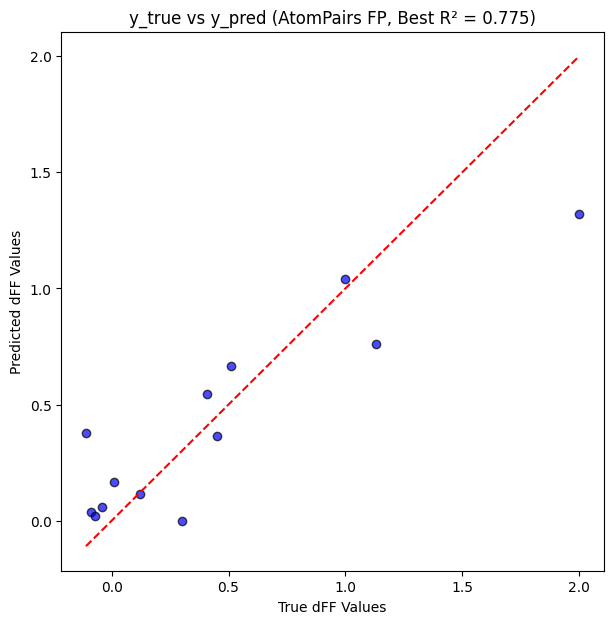

In [ ]:
#ATOMPAIRS LINEAR YPRED VS YTEST
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.svm import SVR
import numpy as np

# Load dataset
df = pd.read_excel('HOMO-LUMO-energies.xlsx')

# Extract SMILES and target variable (dFF)
smiles_list = df["Smiles"]
dff_values = df["dFF"]

# Generate AtomPairs fingerprints
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
atompairs_fingerprints = [AllChem.GetHashedAtomPairFingerprintAsBitVect(mol) for mol in mols]
atompairs_fps_array = np.array([np.array(fp) for fp in atompairs_fingerprints])

# Initialize variables to store the best model's data
best_r2 = float('-inf')
best_y_true = None
best_y_pred = None

# Train models with 200 different random splits
r2_scores = []

with open('r2_scores_atompairs.txt', 'w') as f:
    for i in range(200):
        # Split dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            atompairs_fps_array, dff_values, test_size=0.20, random_state=i
        )

        # Train SVR model with linear kernel
        regressor = SVR(kernel='linear')
        regressor.fit(X_train, y_train)

        # Evaluate the model
        y_pred = regressor.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

        # Save the best model
        if r2 > best_r2:
            best_r2 = r2
            best_y_true = y_test
            best_y_pred = y_pred

        # Save R² scores to file
        print(r2, file=f)

# Save test set predictions for the best model
test_results = pd.DataFrame({'y_true': best_y_true, 'y_pred': best_y_pred})
test_results.to_csv('test_results_atompairs.csv', index=False)

# Plot y_true vs y_pred
plt.figure(figsize=(7, 7))
plt.scatter(best_y_true, best_y_pred, alpha=0.7, edgecolors='k', color='blue')
plt.plot([min(best_y_true), max(best_y_true)], [min(best_y_true), max(best_y_true)], linestyle='--', color='red')
plt.xlabel('True dFF Values')
plt.ylabel('Predicted dFF Values')
plt.title(f'y_true vs y_pred (AtomPairs FP, Best R² = {best_r2:.3f})')
plt.savefig('y_true_vs_y_pred_atompairs.png', dpi=300)
plt.show()



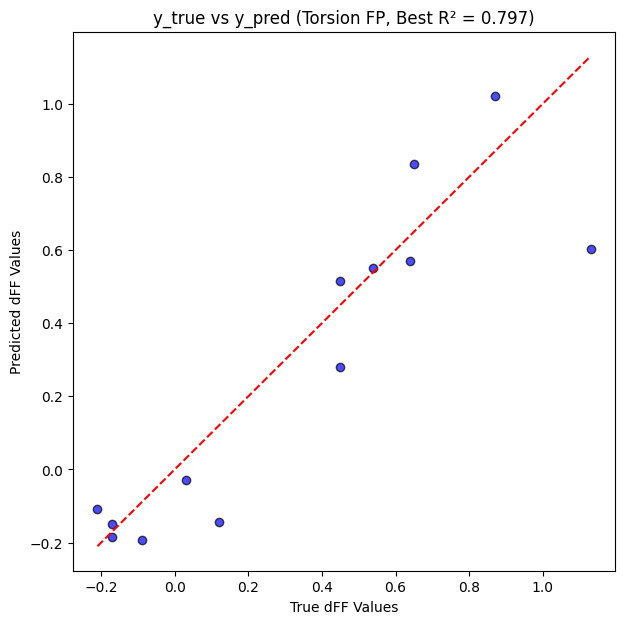

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score

# Load dataset
df = pd.read_excel('HOMO-LUMO-energies.xlsx')

# Extract SMILES and target variable (dFF)
smiles_list = df["Smiles"]
dff_values = df["dFF"]

# Generate Torsion fingerprints
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
torsion_fps = [AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=2048) for mol in mols]
torsion_fps_array = np.array([np.array(fp) for fp in torsion_fps])  # Convert to NumPy array

# Initialize variables to store the best model's data
best_r2 = float('-inf')
best_y_true = None
best_y_pred = None

# Train models with 200 different random splits
r2_scores = []

with open('r2_scores_torsion.txt', 'w') as f:
    for i in range(200):
        # Split dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            torsion_fps_array, dff_values, test_size=0.20, random_state=i
        )

        # Train SVR model
        regressor = SVR(kernel='linear')
        regressor.fit(X_train, y_train)

        # Evaluate the model
        y_pred = regressor.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        r2_scores.append(r2)

        # Save the best model
        if r2 > best_r2:
            best_r2 = r2
            best_y_true = y_test
            best_y_pred = y_pred

        # Save R² scores to file
        print(r2, file=f)

# Save test set predictions for the best model
test_results = pd.DataFrame({'y_true': best_y_true, 'y_pred': best_y_pred})
test_results.to_csv('test_results_torsion.csv', index=False)

# Plot y_true vs y_pred
plt.figure(figsize=(7, 7))
plt.scatter(best_y_true, best_y_pred, alpha=0.7, edgecolors='k', color='blue')
plt.plot([min(best_y_true), max(best_y_true)], [min(best_y_true), max(best_y_true)], linestyle='--', color='red')
plt.xlabel('True dFF Values')
plt.ylabel('Predicted dFF Values')
plt.title(f'y_true vs y_pred (Torsion FP, Best R² = {best_r2:.3f})')
plt.savefig('y_true_vs_y_pred_torsion.png', dpi=300)
plt.show()
